# Integrating the value function correctly

Right now I'm using the generic `scipy.integrate.quad`, which is probably slow (tons of integration points)
and not precise.

It seems it also struggles with some values of lambdas and p.

Objectives:

1. Write a Gauss-Hermite integration procedure
2. Check for accuracy against `scipy.integrate.quad`
3. Check for lambdas, p points where the integration struggles


The integration is over future states of log demand.

$$ \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) b_t(x_{t+1}| a_t, I_t )\; d x_{t+1} = \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) \left[\sum_{l=1}^L p_l(x_{t+1}) \lambda_l\right] \; d x_{t+1} $$

$$ = \sum_{l=1}^L \left[ \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \right] * \lambda_l $$

Since $p_l(x_{t+1})$ is a normal pdf, it makes sense to use Gauss-Hermite integration for each element of the sum above (See Judd(1998) "Numerical Methods in Economics", page 261ff):

$$\int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \approx \pi^{-1/2} \sum_{i=1}^n w_i V(\sqrt{2} \sigma x_i + \mu_l)$$

where $x_i, w_i$ are Gauss-Hermite collocation points and weights and

$$ \mu_l = \alpha + \beta_l \log p_t $$

According to Judd (1998), ~7 nodes might be enough to get a low error.

The sample points and weights are obtained from https://keisan.casio.com/exec/system/1281195844


In [12]:
import sys
sys.path.append("../")
sys.path.append("../examples")
import src
import src.constants as const
import scipy.integrate as integrate
from aguirregabiria_simple import v0
import numpy as np
from typing import Callable
import dill


lambdas = src.generate_simplex_3dims(4)
rand_n = np.random.randint(0, high=len(lambdas))

r_lambda_point = lambdas[rand_n]
print(r_lambda_point)

[0.33333333 0.66666667 0.        ]


In [2]:
v0(r_lambda_point[:-1])

1.81254388137579

In [19]:
i = 1
length_of_price_grid = 10
min_price, max_price = 0.5, 1.5
dmd_transition_fs = src.dmd_transition_fs
update_lambdas = src.update_lambdas
belief = src.belief
wGuess = v0
p_array = np.linspace(min_price, max_price, num=length_of_price_grid) 


for i in range(len(p_array)):
    def new_lambdas(new_dmd):
        return update_lambdas(new_dmd, transition_fs=dmd_transition_fs,
                              old_lambdas=r_lambda_point, action=p_array[i], old_state=2.5)
    
    def new_belief(new_dmd):
        """
        Don't update lambdas! Use the ones from the current period
        """
        return belief(new_dmd, transition_fs=dmd_transition_fs,
                      lambda_weights=r_lambda_point,
                      action=p_array[i], old_state=2.5)

    def integrand(new_dmd):
        return wGuess(new_lambdas(new_dmd)[:-1]) * new_belief(new_dmd)

    logd_min, logd_max = -6, 5#-6, 2.3
    integrated_values, error = integrate.quad(integrand, logd_min, logd_max)
    print(p_array[i], integrated_values)

0.5 1.8718984650262889
0.6111111111111112 1.823408894837528
0.7222222222222222 1.7544727937000566
0.8333333333333333 1.6879042576891523
0.9444444444444444 1.6455083204680672
1.0555555555555556 1.6449257407917766
1.1666666666666665 1.6759757058032823
1.2777777777777777 1.7167068185508567
1.3888888888888888 1.7558935574813115
1.5 1.789834333551749


In [35]:
from scipy import integrate

print("beliefs on: ", p_array[i])
yvals = []
xvals = np.linspace(-6, 5, num=20)
for x in xvals:
    yvals.append(integrand(x))
integrate.trapz(yvals, xvals)

beliefs on:  1.5


1.7891557069558426

In [ ]:
0.5 1.58146867950315
0.6111111111111112 1.5810837077791862
0.7222222222222222 1.5802274822931164
0.8333333333333333 1.5786553583558518
0.9444444444444444 1.5766330632974608
1.0555555555555556 1.5772924234992987
1.1666666666666665 1.5905227980421508
1.2777777777777777 1.6318165509129166
1.3888888888888888 1.702779533449348
1.5 1.7917026242070173




In [28]:
hermite_xs = np.array([-2.6519613568352334924470820065166161144,
-1.6735516287674714450318013983035948191,
             -0.81628788285896466303871095902714581674, 0., 0.8162878828589646630387109590271458167,
1.6735516287674714450318013983035948191, 2.6519613568352334924470820065166161144])

hermite_ws = np.array([9.717812450995191541494242559389596444E-4,
0.054515582819127030592178568841695125961,
0.42560725261012780052031746666639103544,
0.8102646175568073267648765638130949407,
0.42560725261012780052031746666639103544,
0.054515582819127030592178568841695125961,
9.717812450995191541494242559389596444E-4])


#Más nodos:

hermite_xs = np.array([-5.387480890011232862017, -4.603682449550744273078, -3.944764040115625210376,
                       -3.347854567383216326915, -2.78880605842813048053, -2.254974002089275523082,
                       -1.738537712116586206781,
-1.234076215395323007886, -0.7374737285453943587056, -0.2453407083009012499038,
0.2453407083009012499038, 0.7374737285453943587056, 1.234076215395323007886,  
1.738537712116586206781, 2.254974002089275523082, 2.78880605842813048053,   
3.347854567383216326915, 3.944764040115625210376, 4.603682449550744273078,   
5.387480890011232862017])

hermite_ws = np.array([2.22939364553415129252E-13, 4.3993409922731805536E-10,
1.086069370769281694E-7, 7.80255647853206369415E-6, 2.28338636016353967257E-4,
0.00324377334223786183218, 0.0248105208874636108822, 0.1090172060200233200138,
0.2866755053628341297197, 0.46224366960061008965,0.46224366960061008965,
0.28667550536283412972, 0.1090172060200233200138, 0.0248105208874636108822,
0.00324377334223786183218, 2.283386360163539672572E-4, 7.8025564785320636941E-6,
1.086069370769281694E-7, 4.39934099227318055363E-10, 2.22939364553415129252E-13])  

## New Belief check

New belief should be a gaussian mixture density.

Does it behave that way?

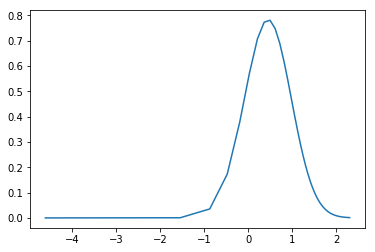

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt


def new_belief(new_dmd):
    return belief(new_dmd, transition_fs=dmd_transition_fs,
                  lambda_weights=new_lambdas(new_dmd),
                  action=p_array[i], old_state=2.5)

new_beliefs_vals = []
#rescaled_demands = rescale_demand(hermite_point, beta_l, p_array)
rescaled_demands = np.log(np.linspace(0.01, 10, 50))
for dmd in rescaled_demands:
    new_beliefs_vals.append(new_belief(dmd))

fig, ax = plt.subplots(1, 1)
ax.plot(rescaled_demands, new_beliefs_vals)

1.5


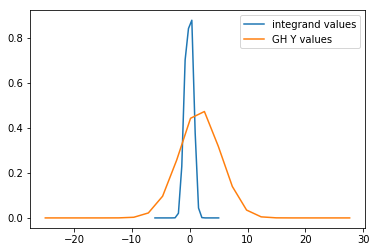

In [47]:
fig, ax = plt.subplots(1, 1)
ax.plot(xvals, yvals, label='integrand values')

#p1.5
print(p_array[i])
ghxvals, ghyvals = gauss_hermite_y_values(v0, p_array[i], r_lambda_point, hermite_xs, hermite_ws)
ax.plot(ghxvals, np.pi**(-0.5)*ghyvals, label='GH Y values')
ax.legend()

In [73]:
hermite_point = hermite_xs[4]
beta_l = const.betas_transition[0]
rescaled_demand = rescale_demand(hermite_point, beta_l, p_array) 

In [29]:
for hpoint in hermite_xs:
    print(hpoint, rescale_demand(hpoint, beta_l=0.3, price=p_array[0]))

-5.387480890011233 -4.595425044179217
-4.603682449550744 -3.8116266037187287
-3.944764040115625 -3.1527081942836097
-3.3478545673832163 -2.555798721551201
-2.7888060584281305 -1.9967502125961145
-2.2549740020892757 -1.4629181562572597
-1.7385377121165861 -0.9464818662845702
-1.234076215395323 -0.4420203695633069
-0.7374737285453944 0.05458211728662188
-0.24534070830090124 0.5467151375311151
0.24534070830090124 1.0373965541329178
0.7374737285453944 1.5295295743774109
1.234076215395323 2.0261320612273397
1.7385377121165861 2.530593557948603
2.2549740020892757 3.0470298479212925
2.7888060584281305 3.5808619042601473
3.3478545673832163 4.139910413215233
3.944764040115625 4.736819885947643
4.603682449550744 5.3957382953827615
5.387480890011233 6.17953673584325


In [46]:

sqrt2 = np.sqrt(2)

def rescale_demand(dmd, beta_l, price):
    """
    Rescales demand to use Gauss-Hermite collocation points
    """
    mu = const.α + beta_l*np.log(price)
    return sqrt2*const.σ_ɛ * dmd + mu

def gauss_hermite_integrate(f, price, lambdas, hermite_xs, hermite_ws):
    """
    Integrates f with Guass-Hermite
    """
    sum_over_each_lambda = 0.
    for l, beta_l in enumerate(const.betas_transition):
        for k, hermite_point in enumerate(hermite_xs):
            rescaled_demand = rescale_demand(hermite_point, beta_l, price)            
            new_lambdas_value = new_lambdas(rescaled_demand)
            v_value = f(new_lambdas_value[:-1])
            sum_over_each_lambda += f(new_lambdas_value[:-1])*hermite_ws[k]*lambdas[l]
    
    return np.pi**(-0.5)*sum_over_each_lambda

def gauss_hermite_y_values(f, price, lambdas, hermite_xs, hermite_ws):
    yvals = np.empty_like(hermite_xs)
    xvals = np.empty_like(hermite_xs)
    for k, hermite_point in enumerate(hermite_xs):
        yvals[k] = 0.
        xvals[k] = 0.
        for l, beta_l in enumerate(const.betas_transition):
            rescaled_demand = rescale_demand(hermite_point, beta_l, price)
            xvals[k] += rescaled_demand*beta_l
            new_lambdas_value = new_lambdas(rescaled_demand)
            v_value = f(new_lambdas_value[:-1])
            yvals[k] += f(new_lambdas_value[:-1])*lambdas[l]*hermite_ws[k]
    
    return xvals, yvals

for p in p_array:
    value = gauss_hermite_integrate(v0, p, r_lambda_point, hermite_xs, hermite_ws)
    print(p, value)

0.5 1.5814688248870796
0.6111111111111112 1.581077348397766
0.7222222222222222 1.580235976862888
0.8333333333333333 1.5787361763012677
0.9444444444444444 1.5765775715956087
1.0555555555555556 1.5767850452624783
1.1666666666666665 1.5906806885880973
1.2777777777777777 1.6327213535183351
1.3888888888888888 1.7041802687295133
1.5 1.7898435268048578


In [ ]:
0.5 1.8718984650262889
0.6111111111111112 1.823408894837528
0.7222222222222222 1.7544727937000566
0.8333333333333333 1.6879042576891523
0.9444444444444444 1.6455083204680672
1.0555555555555556 1.6449257407917766
1.1666666666666665 1.6759757058032823
1.2777777777777777 1.7167068185508567
1.3888888888888888 1.7558935574813115
1.5 1.789834333551749


In [62]:
hermite_point = hermite_xs[4]
beta_l = const.betas_transition[0]
np.e**rescale_demand(hermite_point, beta_l, p_array) 

array([38.73115206, 21.21338081, 12.85162032,  8.36592885,  5.74699977,
        4.11649072,  3.04880789,  2.32062216,  1.80704063,  1.43448711])

$$\int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \approx \pi^{-1/2} \sum_{i=1}^n w_i V(\sqrt{2} \sigma x_i + \mu_l)$$

In [29]:
rescale_demand(hermite_xs, -3, price=1.4)

array([-1.88463657, -1.19279642, -0.58661941, -0.00941671,  0.56778599,
        1.173963  ,  1.86580315])

In [23]:
const.betas_transition

array([-3. , -2.5, -2. ])

## Using QuadPy

In [83]:
import quadpy
val = quadpy.e1r2.integrate(
    lambda x: x**2,
    quadpy.e1r2.GaussHermite(5)
    )
val

0.8862269254527577

In [86]:
def simple_gauss_hermite(f, hermite_xs, hermite_ws):
    return np.pi**(-0.5)*np.dot(f(hermite_xs), hermite_ws)

def example_f(x):
    return x**2

simple_gauss_hermite(example_f, hermite_xs, hermite_ws)


0.49999999999999994